In [46]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
%run "./common_init.ipynb"

In [48]:
%autoreload 2
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load custom code
import kdd98.data_handler as dh
from kdd98.config import Config
import pickle

In [49]:
# Where to save the figures
PROJECT_ROOT_DIR = "../../"
CHAPTER_ID = "gradient_boosting"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "figures", CHAPTER_ID)

if not os.path.exists(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [50]:
with open(pathlib.Path(Config.get("df_store"), "learn_features.pkl"), "rb") as f:
    kdd98_learn_feat = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "learn_targets.pkl"), "rb") as f:
    kdd98_learn_targets = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "test_features.pkl"), "rb") as f:
    kdd98_test_feat = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "test_targets.pkl"), "rb") as f:
    kdd98_test_targets = pickle.load(f)
    
# Extracting the data and resetting target to [-1, 1]
train_features = kdd98_learn_feat.values
train_target = kdd98_learn_targets.loc[:,"TARGET_B"].astype("int64").values
test_features = kdd98_test_feat.values
test_target = kdd98_test_targets.loc[:,"TARGET_B"].astype("int64").values

# Setting up the classifier 

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Balancing target

In [ ]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(sampling_strategy='minority',
                 random_state=Config.get("random_seed"))
X_resampled, y_resampled = smt.fit_resample(train_features, train_target)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ovs = RandomOverSampler(sampling_strategy="minority", random_state=Config.get("random_seed"))
X_resampled, y_resampled = ovs.fit_resample(train_features, train_target)

In [ ]:
y_resampled.shape

# Take 1: GridSearchCV

## Grid search

In [ ]:
param_grid = {
    "max_depth": [2,6],
    "n_estimators": [100,400, 600],
    "subsample": [1.0, 1/2],
    "learning_rate": [0.1, 0.2]
}

In [ ]:
grid_search = GridSearchCV(
                  GradientBoostingClassifier(verbose=1, random_state=Config.get("random_seed")),
                  param_grid,
                  scoring= "recall",# "balanced_accuracy", "neg_log_loss", "precision"
                  n_jobs=-1,
                  cv=3)

In [ ]:
grid_search.fit(X_resampled, y_resampled)

## Predictions and confusion matrix

In [ ]:
predict_y = grid_search.predict(test_features)
true_y = test_target

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_y,predict_y)

In [15]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
plot_confusion_matrix(true_y, predict_y, [-1,1], normalize=False, cmap=Config.get("color_map"))

In [ ]:
best = grid_search.best_estimator_

## Important features

In [ ]:
best.get_params()

In [ ]:
features = best.feature_importances_
important_features = pd.DataFrame(data=features, index=kdd98_learn_feat.columns, columns=["feature_importance"])

In [ ]:
important_features = important_features.sort_values(ascending=False, by="feature_importance")
important_features

In [ ]:
plt.rcParams['figure.figsize'] = (14, 10)
important_features.head(n=30).sort_values(ascending=True, by="feature_importance").plot.barh()

In [ ]:
import pathlib
import pickle
pathlib.Path(Config.get("model_store")).mkdir(parents=True, exist_ok=True)
with open(pathlib.Path(Config.get("model_store"),"gridsearch_gradboost.pkl"),"wb") as o:
    pickle.dump(grid_search, o)

# Take 2: RandomizedGridSearch

## Feature Selection

In [10]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

In [11]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf,
                         n_estimators='auto',
                         verbose=2,
                         random_state=Config.get("random_seed"))

In [12]:
# find all relevant features
feat_selector.fit(kdd98_learn_feat.values, kdd98_learn_targets.TARGET_B.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	660
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	660
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	660
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	660
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	660
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	660
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	660
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	74
Tentative: 	70
Rejected: 	516


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	74
Tentative: 	70
Rejected: 	516


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	74
Tentative: 	70
Rejected: 	516


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	74
Tentative: 	70
Rejected: 	516


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	74
Tentative: 	54
Rejected: 	532


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	74
Tentative: 	54
Rejected: 	532


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	74
Tentative: 	54
Rejected: 	532


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	74
Tentative: 	54
Rejected: 	532


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	75
Tentative: 	44
Rejected: 	541


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	75
Tentative: 	44
Rejected: 	541


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	75
Tentative: 	44
Rejected: 	541


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	75
Tentative: 	35
Rejected: 	550


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	75
Tentative: 	35
Rejected: 	550


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	75
Tentative: 	35
Rejected: 	550


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	75
Tentative: 	27
Rejected: 	558


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	75
Tentative: 	27
Rejected: 	558


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	75
Tentative: 	27
Rejected: 	558


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	75
Tentative: 	27
Rejected: 	558


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	75
Tentative: 	27
Rejected: 	558


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	75
Tentative: 	27
Rejected: 	558


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	75
Tentative: 	26
Rejected: 	559


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	75
Tentative: 	23
Rejected: 	562


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	75
Tentative: 	23
Rejected: 	562


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	75
Tentative: 	23
Rejected: 	562


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	75
Tentative: 	17
Rejected: 	568


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	75
Tentative: 	17
Rejected: 	568


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	75
Tentative: 	15
Rejected: 	570


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	75
Tentative: 	15
Rejected: 	570


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	75
Tentative: 	15
Rejected: 	570


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	75
Tentative: 	14
Rejected: 	571


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	75
Tentative: 	14
Rejected: 	571


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	75
Tentative: 	14
Rejected: 	571


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	75
Tentative: 	12
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	75
Tentative: 	12
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	75
Tentative: 	12
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	75
Tentative: 	12
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	75
Tentative: 	12
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	75
Tentative: 	12
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	75
Tentative: 	12
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	75
Tentative: 	12
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	75
Tentative: 	12
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	75
Tentative: 	12
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	75
Tentative: 	12
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	75
Tentative: 	12
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	75
Tentative: 	12
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	75
Tentative: 	12
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 100
Confirmed: 	76
Tentative: 	11
Rejected: 	573


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 100
Confirmed: 	76
Tentative: 	10
Rejected: 	574


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 100
Confirmed: 	76
Tentative: 	10
Rejected: 	574


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 100
Confirmed: 	76
Tentative: 	10
Rejected: 	574


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 100
Confirmed: 	76
Tentative: 	10
Rejected: 	574


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 100
Confirmed: 	76
Tentative: 	10
Rejected: 	574


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 100
Confirmed: 	76
Tentative: 	10
Rejected: 	574


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 100
Confirmed: 	76
Tentative: 	10
Rejected: 	574


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 100
Confirmed: 	76
Tentative: 	10
Rejected: 	574


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 100
Confirmed: 	76
Tentative: 	10
Rejected: 	574


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 100
Confirmed: 	76
Tentative: 	10
Rejected: 	574


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 100
Confirmed: 	76
Tentative: 	9
Rejected: 	575


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 100
Confirmed: 	76
Tentative: 	9
Rejected: 	575


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 100
Confirmed: 	76
Tentative: 	9
Rejected: 	575


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 100
Confirmed: 	76
Tentative: 	9
Rejected: 	575


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 100
Confirmed: 	76
Tentative: 	9
Rejected: 	575


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 100
Confirmed: 	77
Tentative: 	8
Rejected: 	575


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 100
Confirmed: 	77
Tentative: 	8
Rejected: 	575


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 100
Confirmed: 	77
Tentative: 	8
Rejected: 	575


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 100
Confirmed: 	77
Tentative: 	8
Rejected: 	575


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 100
Confirmed: 	77
Tentative: 	8
Rejected: 	575


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 100
Confirmed: 	77
Tentative: 	8
Rejected: 	575


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 100
Confirmed: 	77
Tentative: 	8
Rejected: 	575


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 100
Confirmed: 	77
Tentative: 	8
Rejected: 	575


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 100
Confirmed: 	77
Tentative: 	8
Rejected: 	575
Iteration: 	99 / 100
Confirmed: 	77
Tentative: 	8
Rejected: 	575


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	77
Tentative: 	1
Rejected: 	575


/data/anaconda/envs/py36/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=260, n_jobs=-1, oob_score=False,
            random_state=<mtrand.RandomState object at 0x7fdd441473a8>,
            verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x7fdd441473a8>,
     two_step=True, verbose=2)

In [54]:
# call transform() on X to filter it down to selected features
X_train = feat_selector.transform(kdd98_learn_feat.values)
X_test = feat_selector.transform(kdd98_test_feat.values)

In [16]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(sampling_strategy='minority',
                 random_state=Config.get("random_seed"))
X_resampled, y_resampled = smt.fit_resample(X_train, train_target)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 72332), (1, 72332)]


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=Config.get("random_seed"),
                         replacement=True,
                        )
X_resampled, y_resampled = rus.fit_resample(X_train, train_target)

In [56]:
from imblearn.over_sampling import RandomOverSampler

ovs = RandomOverSampler(sampling_strategy="minority", random_state=Config.get("random_seed"))
X_resampled, y_resampled = ovs.fit_resample(X_train, train_target)

In [57]:
import scipy.stats
# We use stochastic gradient boosting (subsample < 1),
# a maximum depth of up to 8,
# a very small learning rate combined with early stopping if there's no improvement
param_distrib = {
    "max_depth": scipy.stats.randint(2,5),
    "n_estimators": [1000,2000],
    "subsample": [1/2],
    "learning_rate": scipy.stats.uniform(loc=.01,scale=0.1)
}

In [58]:
random_grid_search = RandomizedSearchCV(
    GradientBoostingClassifier(
        verbose=1, random_state=Config.get("random_seed"), n_iter_no_change=5),
    param_distrib,
    scoring=
    "recall",  # "f1", "balanced_accuracy" # , "neg_log_loss", "precision", "recall"
    n_jobs=-1,
    cv=5,
    refit=True,
    verbose=3)

In [59]:
random_grid_search.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 40.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 96.3min finished


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3791           0.0068           14.63m
         2           1.3734           0.0056           14.75m
         3           1.3682           0.0051           14.73m
         4           1.3633           0.0049           14.71m
         5           1.3587           0.0042           14.74m
         6           1.3551           0.0040           14.75m
         7           1.3503           0.0039           14.72m
         8           1.3466           0.0035           14.71m
         9           1.3427           0.0034           14.68m
        10           1.3408           0.0028           14.68m
        20           1.3137           0.0020           14.53m
        30           1.2960           0.0016           14.38m
        40           1.2809           0.0012           14.28m
        50           1.2700           0.0011           14.15m
        60           1.2577           0.0009           14.00m
       

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=1, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdce79b1ef0>, 'n_estimators': [1000], 'subsample': [0.5], 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdce78770b8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='recall', verbose=3)

## Predictions and confusion matrix

In [60]:
rgs_predict_y = random_grid_search.predict(X_test)
true_y = test_target

In [61]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_y,rgs_predict_y, labels=[1,0])

array([[  234,   735],
       [ 2504, 15610]])

Normalized confusion matrix
[[0.24148607 0.75851393]
 [0.13823562 0.86176438]]


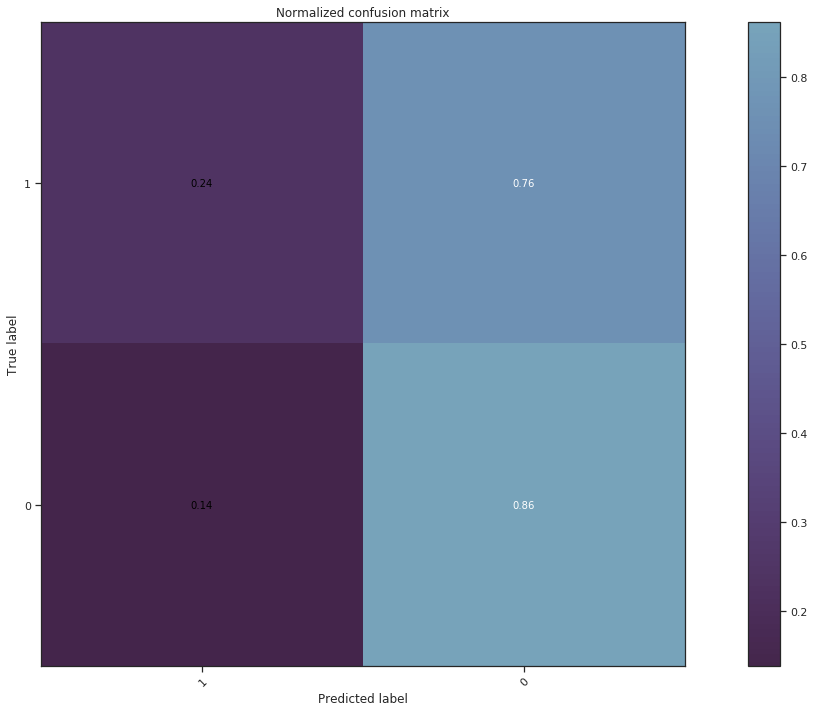

In [78]:
plot_confusion_matrix(true_y, rgs_predict_y, [1,0], normalize=True, cmap=Config.get("color_map"))

In [63]:
rgs_best = random_grid_search.best_estimator_

## Important features

In [64]:
rgs_best.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.07064218275975508,
 'loss': 'deviance',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_iter_no_change': 5,
 'presort': 'auto',
 'random_state': 42,
 'subsample': 0.5,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 1,
 'warm_start': False}

In [65]:
features = kdd98_learn_feat.columns.values[feat_selector.support_]

In [66]:
features

array(['AGE', 'NUMCHLD', 'WEALTH2', 'PEPSTRFL', 'HV1', 'HV2', 'HVP1',
       'HVP2', 'HVP3', 'HVP4', 'DMA', 'IC4', 'IC5', 'HHAS3', 'POBC2',
       'CARDPROM', 'NUMPROM', 'CARDPM12', 'NUMPRM12', 'RAMNT_8',
       'RAMNT_9', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14',
       'RAMNT_16', 'RAMNT_22', 'RAMNT_24', 'RAMNTALL', 'NGIFTALL',
       'CARDGIFT', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'AVGGIFT',
       'RFA_2F', 'RFA_2A', 'RFA_3F', 'RFA_3A', 'RFA_4F', 'RFA_4A',
       'RFA_5F', 'RFA_5A', 'RFA_6F', 'RFA_6A', 'RFA_7A', 'RFA_8F',
       'RFA_8A', 'RFA_9F', 'RFA_9A', 'RFA_10A', 'RFA_11F', 'RFA_11A',
       'RFA_12A', 'RFA_13A', 'RFA_14A', 'RFA_16A', 'RFA_23F',
       'ZIP_longitude', 'MONTHS_TO_DONATION_9', 'MONTHS_TO_DONATION_14',
       'MONTHS_TO_DONATION_15', 'MONTHS_TO_DONATION_19',
       'MONTHS_TO_DONATION_22', 'MONTHS_TO_DONATION_24',
       'LASTDATE_DELTA_MONTHS', 'MAXRDATE_DELTA_MONTHS',
       'ODATEDW_DELTA_YEARS', 'GEOCODE_02', 'RFA_3R_S', 'RFA_4R_S',
       'RFA_6R_S',

In [67]:
rgs_features = rgs_best.feature_importances_
rgs_important_features = pd.DataFrame(data=rgs_features, index=features, columns=["feature_importance"])

In [68]:
rgs_important_features = rgs_important_features.sort_values(ascending=False, by="feature_importance")
rgs_important_features

,feature_importance
RAMNT_11,0.047248
NUMCHLD,0.040668
AGE,0.034512
RAMNT_22,0.033416
MONTHS_TO_DONATION_22,0.030837
MONTHS_TO_DONATION_15,0.029891
MONTHS_TO_DONATION_9,0.029141
MONTHS_TO_DONATION_14,0.028830
RAMNT_16,0.026967
ZIP_longitude,0.024673


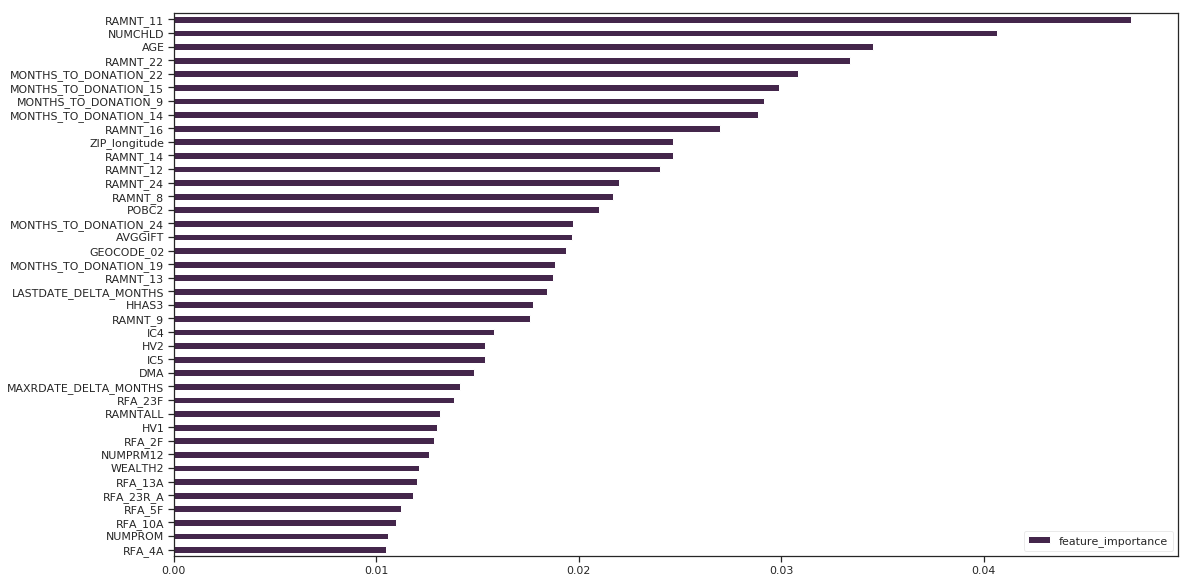

In [69]:
plt.rcParams['figure.figsize'] = (18, 10)
rgs_important_features.head(n=40).sort_values(ascending=True, by="feature_importance").plot.barh()

In [70]:
import pathlib
import pickle
pathlib.Path(Config.get("model_store")).mkdir(parents=True, exist_ok=True)
with open(pathlib.Path(Config.get("model_store"),"random_gridsearch_boruta_oversampling_gradboost.pkl"),"wb") as o:
    pickle.dump(random_grid_search, o)

In [79]:
gb = GradientBoostingClassifier(
    criterion='friedman_mse',
    init=None,
    learning_rate=0.1,
    loss='deviance',
    max_depth=2,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    min_weight_fraction_leaf=0.0,
    n_estimators=2000,
    n_iter_no_change=5,
    presort='auto',
    random_state=42,
    subsample=0.5,
    tol=0.0001,
    validation_fraction=0.1,
    verbose=1)

In [80]:
gb.fit(X_resampled, y_resampled)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3801           0.0060           11.04m
         2           1.3756           0.0044           11.26m
         3           1.3714           0.0042           11.38m
         4           1.3680           0.0036           11.37m
         5           1.3649           0.0032           11.47m
         6           1.3626           0.0026           11.47m
         7           1.3591           0.0024           11.49m
         8           1.3568           0.0024           11.48m
         9           1.3548           0.0020           11.48m
        10           1.3540           0.0019           11.52m
        20           1.3383           0.0012           11.44m
        30           1.3307           0.0006           11.44m
        40           1.3233           0.0006           11.40m
        50           1.3188           0.0003           11.35m
        60           1.3130           0.0004           11.31m
       

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=2000,
              n_iter_no_change=5, presort='auto', random_state=42,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=1, warm_start=False)

In [81]:
y_predict = gb.predict(X_test)
y_true = test_target

In [82]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,y_predict, labels=[1,0])

array([[  388,   581],
       [ 4424, 13690]])

Normalized confusion matrix
[[0.4004128  0.5995872 ]
 [0.24423098 0.75576902]]


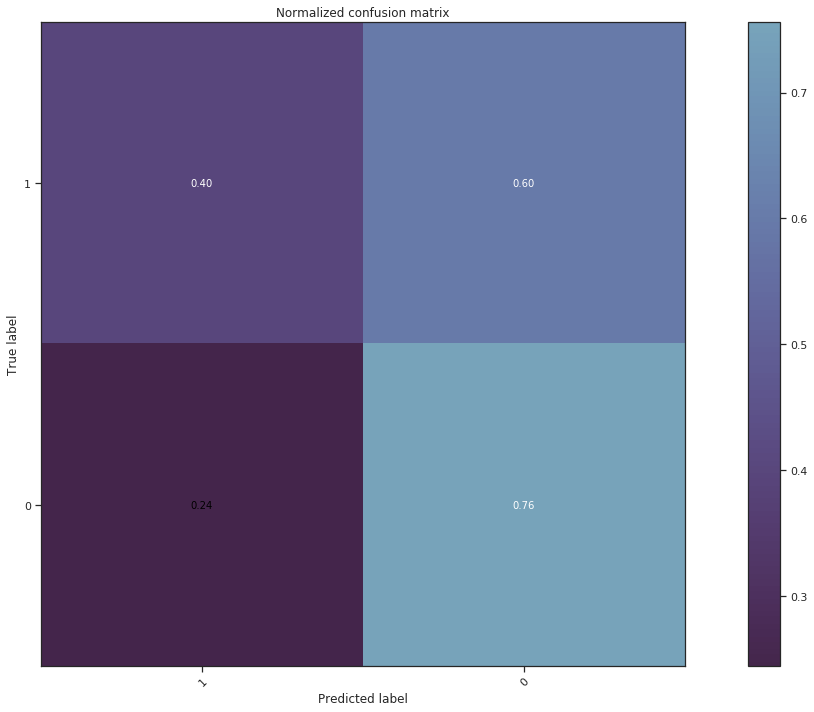

In [83]:
plot_confusion_matrix(y_true, y_predict, [1,0], normalize=True, cmap=Config.get("color_map"))

In [90]:
gb2 = GradientBoostingClassifier(
    criterion='friedman_mse',
    init=None,
    learning_rate=0.01,
    loss='deviance',
    max_depth=2,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    min_weight_fraction_leaf=0.0,
    n_estimators=2000,
    n_iter_no_change=5,
    presort='auto',
    random_state=42,
    subsample=0.5,
    tol=0.0001,
    validation_fraction=0.1,
    verbose=1)

In [91]:
gb2.fit(X_resampled, y_resampled)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3856           0.0006           11.99m
         2           1.3851           0.0005           11.79m
         3           1.3845           0.0006           11.65m
         4           1.3840           0.0006           11.61m
         5           1.3834           0.0005           11.62m
         6           1.3829           0.0006           11.74m
         7           1.3823           0.0005           11.82m
         8           1.3818           0.0006           11.79m
         9           1.3812           0.0005           11.77m
        10           1.3809           0.0005           11.75m
        20           1.3758           0.0005           11.70m
        30           1.3718           0.0004           11.59m
        40           1.3682           0.0003           11.50m
        50           1.3654           0.0003           11.46m
        60           1.3625           0.0003           11.38m
       

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=2000,
              n_iter_no_change=5, presort='auto', random_state=42,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=1, warm_start=False)

In [92]:
y_predict_2 = gb2.predict(X_test)
y_true = test_target

In [93]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,y_predict_2, labels=[1,0])

array([[  554,   415],
       [ 6726, 11388]])

Normalized confusion matrix
[[0.57172343 0.42827657]
 [0.371315   0.628685  ]]


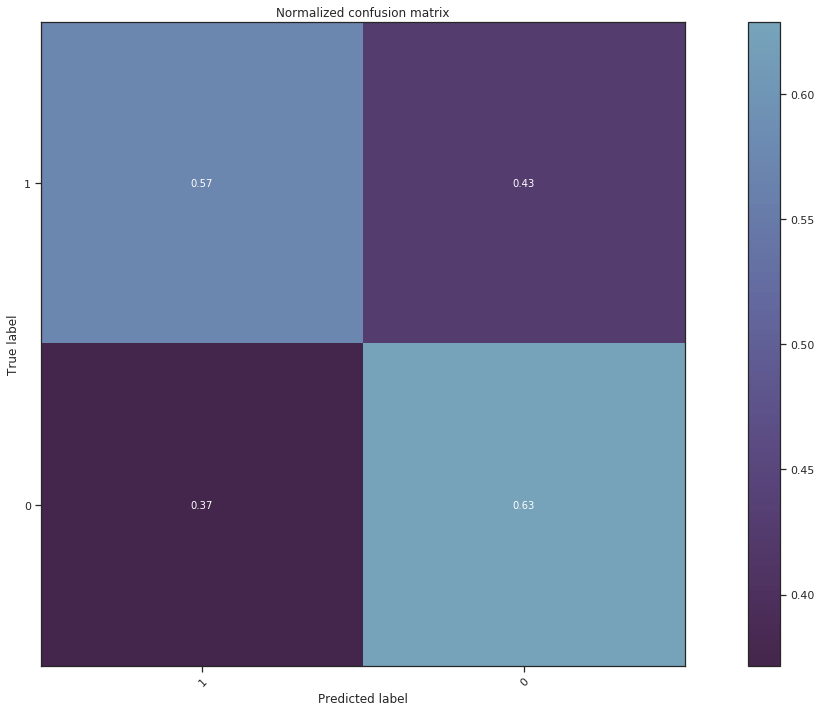

In [94]:
plot_confusion_matrix(y_true, y_predict_2, [1,0], normalize=True, cmap=Config.get("color_map"))

In [89]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(sampling_strategy='minority',
                 random_state=Config.get("random_seed"))
X_resampled_combined, y_resampled_combined = smt.fit_resample(X_train, train_target)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 72455), (1, 72455)]


#  XGBoost

In [113]:
# We use stochastic gradient boosting (subsample < 1),
# a maximum depth of 2 or 3,
# a very small learning rate combined with early stopping if there's no improvement
param_grid = {
    "max_depth": [2, 4, 8],
    "n_estimators": [1000, 2000],
    "subsample": [1/2],
    "learning_rate": [0.005,0.01,0.02],   
}

In [114]:
from xgboost import XGBClassifier

In [115]:
random_grid_search_2 = GridSearchCV(
    XGBClassifier(verbose=1, booster= "gbtree", seed=Config.get("random_seed")),
    param_grid,
    scoring = "recall",  # "f1", "balanced_accuracy" # , "neg_log_loss", "precision", "recall"
    n_jobs=-1,
    cv=5,
    refit=True,
    verbose=3)

In [ ]:
random_grid_search_2.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 24.1min
